# [IAPR 2018:][iapr2018] Lab 2 ‒  Object description

**Author:** Mathieu LAMIOT, Sohyeong KIM

**Due date:** 04.05.2018

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

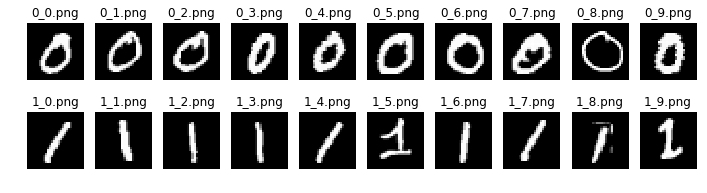

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors

The following code uses findContours from OpenCV to get the  contours. We then discard irrelevant ones (small ones, artefacts) to only keep the "main" contour. We then plot the result.


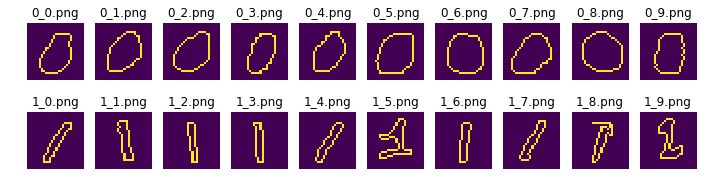

In [3]:
#---------------CONTOUR EXTRACTION--------------------------------------------------------

import cv2 as cv
import numpy as np

minimum_length = 28*28; #This variable tracks the shorter contour. We will later fit all contour so that they contain the same number of points.
labels = [];
contour_list = [];

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))


for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    pic = np.zeros(im.shape) #Black background to plot the contours on
    im2, contours, hierarchy  = cv.findContours(im, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) #Find the external contour
    
    #Keep only the longer contour (to discard artefacts)
    contour_length = 0;
    for contour in contours:
        if len(contour)>contour_length:
            main_contour = contour;
            contour_length = len(contour)
    
    minimum_length = min(contour_length, minimum_length)
    
    cv.drawContours(pic, contours, -1, (255,255,255), 1) #Draw the external conto.ur
    ax.imshow(pic) #Display the result
    ax.axis('off')
    ax.set_title(nm)
    
    #Store that contour and its label
    labels.append(0);
    contour_list.append(main_contour);
    
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    pic = np.zeros(im.shape) #Black background to plot the contours on
    im2, contours, hierarchy  = cv.findContours(im, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) #Find the external contour
    
    #Keep only the longer contour (to discard artefacts)
    contour_length = 0;
    for contour in contours:
        if len(contour)>contour_length:
            main_contour = contour;
            contour_length = len(contour)

    minimum_length = min(contour_length, minimum_length)        
            
    cv.drawContours(pic, main_contour, -1, (255,255,255), 1) #Draw the external contour
    ax.imshow(pic) #Display the result
    ax.axis('off')
    ax.set_title(nm)
    
    #Store that contour and its label
    labels.append(1);
    contour_list.append(main_contour);
    
plt.show()

Here, we make sure that all contours have the same length (which is the length of the smaller contour we found). To do that, we regularly discard points in the contour if it is too long.

In [4]:
#-----------CONTOUR LENGTH NORMALIZATION-------------------------------
#All contours must have the same number of pixels.

normalized_contour_list = [];

for contour in contour_list:
    normalized_contour = [];
    Npoints_to_discard = len(contour)-minimum_length;#Number of points to discard
    
    if Npoints_to_discard>0: #compute the frequency at which we should discard points
        discard_interval = np.floor(len(contour)/Npoints_to_discard)
    else:
        discard_interval = minimum_length+1
    
    #Actually process the signal : Discard and form the complex signal
    points_added_in_a_row = 0
    points_discarded = 0;
    for k in range(0,len(contour)):
        if points_added_in_a_row==discard_interval-1 and points_discarded<Npoints_to_discard:
            points_added_in_a_row = 0
            points_discarded = points_discarded +1
        else:
            point = contour[k]
            normalized_contour.append(point[0,0]+point[0,1]*1j)  
            points_added_in_a_row = points_added_in_a_row+1
    normalized_contour_list.append(normalized_contour)
        

We compute the fourier transfrom of the contour.

In [5]:
#--------------COMPUTE FFT---------------------------------------
fft_list = [];
for contour in normalized_contour_list:
    fft_list.append(np.fft.fft(contour))

We then extract two features. The following ones allow us to differentiate the ones and the zeros. Since we don't use the very first fourier coefficient, the features are translation-invariant. We only use absolute values of the fourier coefficient so the features are rotation-invariant. We don't scale the fourier coefficient with another one, hence the features are scaling-variant.

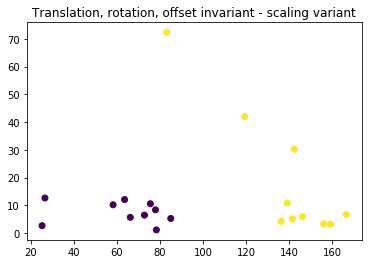

In [6]:
#----------------EXTRACT 2 FEATURES AND PLOT----------------------
x = [];
y = [];
for contour in fft_list:
    x.append(np.absolute(contour[1]))
    y.append(np.absolute(contour[3]))
plt.scatter(x,y,c=labels)
plt.title('Translation, rotation, offset invariant - scaling variant')
plt.show()

In the following part, we modify the images (translation, rotation, scaling) to see if the features are invariant or not.

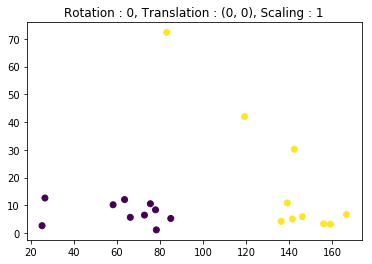

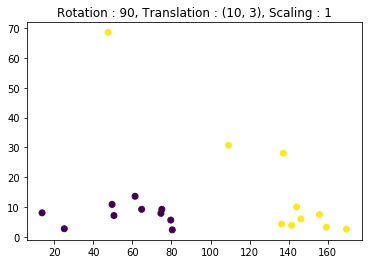

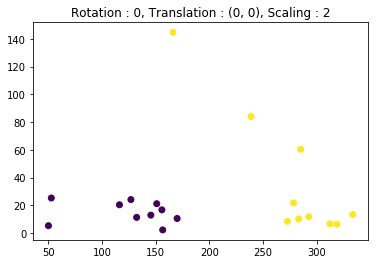

In [7]:
#-----------------------------------------------------------------------
#---------------ROTATED, SCALED, TRANSLATED IMAGES--------------------------------------------------------
#-----------------------------------------------------------------------



def rotateImage(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LINEAR)
  return result
#---------------CONTOUR EXTRACTION--------------------------------------------------------

import cv2 as cv
import numpy as np


def fourierFeatures01(angle,translation,scaling):
    minimum_length = 28*28; #This variable tracks the shorter contour. We will later fit all contour so that they contain the same number of points.
    labels = [];
    contour_list = [];
    for im, nm in zip(zeros_im, zeros_names):
        pic = np.zeros(im.shape) #Black background to plot the contours on

        #ROTATION HERE and Find the external contour
        im2, contours, hierarchy  = cv.findContours(rotateImage(im,angle), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) 

        #Keep only the longer contour (to discard artefacts)
        contour_length = 0;
        for contour in contours:
            if len(contour)>contour_length:
                main_contour = contour;
                contour_length = len(contour)

        minimum_length = min(contour_length, minimum_length)

        cv.drawContours(pic, contours, -1, (255,255,255), 1) #Draw the external conto.ur

        #Store that contour and its label
        labels.append(0);
        contour_list.append(main_contour);

    for im, nm in zip(ones_im, ones_names):
        pic = np.zeros(im.shape) #Black background to plot the contours on
        
        #ROTATION HERE and Find the external contour
        im2, contours, hierarchy  = cv.findContours(rotateImage(im,angle), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) 
        
        #Keep only the longer contour (to discard artefacts)
        contour_length = 0;
        for contour in contours:
            if len(contour)>contour_length:
                main_contour = contour;
                contour_length = len(contour)

        minimum_length = min(contour_length, minimum_length)        

        cv.drawContours(pic, main_contour, -1, (255,255,255), 1) #Draw the external contour


        #Store that contour and its label
        labels.append(1);
        contour_list.append(main_contour);

    #plt.show()

    #-----------CONTOUR LENGTH NORMALIZATION-------------------------------
    #All contours must have the same number of pixels.

    normalized_contour_list = [];

    for contour in contour_list:
        normalized_contour = [];
        Npoints_to_discard = len(contour)-minimum_length;#Number of points to discard

        if Npoints_to_discard>0: #compute the frequency at which we should discard points
            discard_interval = np.floor(len(contour)/Npoints_to_discard)
        else:
            discard_interval = minimum_length+1

        #Actually process the signal : Discard and form the complex signal
        points_added_in_a_row = 0
        points_discarded = 0;
        for k in range(0,len(contour)):
            if points_added_in_a_row==discard_interval-1 and points_discarded<Npoints_to_discard:
                points_added_in_a_row = 0
                points_discarded = points_discarded +1
            else:
                #SCALING & TRANSLATION HERE : 
                point = scaling*(contour[k] + translation);
                normalized_contour.append(point[0,0]+point[0,1]*1j)  
                points_added_in_a_row = points_added_in_a_row+1
        normalized_contour_list.append(normalized_contour)

    #--------------COMPUTE FFT---------------------------------------
    fft_list = [];
    for contour in normalized_contour_list:
        fft_list.append(np.fft.fft(contour))

    #----------------EXTRACT 2 FEATURES AND PLOT----------------------
    x = [];
    y = [];
    for contour in fft_list:
        x.append(np.absolute(contour[1]))
        y.append(np.absolute(contour[3]))
    plt.scatter(x,y,c=labels)
    plt.title('Rotation : {}, Translation : {}, Scaling : {}'.format(angle,translation,scaling))
    plt.show()
    return;
fourierFeatures01(0,(0,0),1)
fourierFeatures01(90,(10,3),1)
fourierFeatures01(0,(0,0),2)

The features appear to be independant of the rotation and translation. (Dots might be a little different because of rotation. This is due to the length normalization of the contour : Because of the rotation, the remaining points of the normalized contour are not necesseraly the same). Still, the features are good enough to differentiate ones and zeros. The separation between both domaines doesn't have to be modified after rotation and/or translation.

On the other hand, the scaling also scales the features. Hence, the separation between the domains of ones and zeros should be re-computed.

### 1.3 Additional method(s)

## Skeleton-based method 

The skeleton of those numbers is quite similar to the image itself as the shapes have quite a constant thickness. The skeleton are displayed in the following code.

Using a skeleton description might not be very useful in this case.

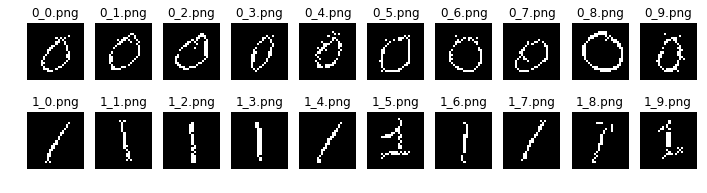

In [8]:
from skimage.morphology import skeletonize

def skeletonize(im):
    size = np.size(im)
    skeleton = np.zeros(im.shape,np.uint8)

    ret,img = cv.threshold(im,127,255,0)
    kernel = cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
    finished = False
    while(not finished):
        eroded = cv.erode(img,kernel)
        temp = cv.dilate(eroded,kernel)
        temp = cv.subtract(img,temp)
        skeleton = cv.bitwise_or(skeleton,temp)
        img = eroded.copy()

        zeros = size - cv.countNonZero(img)
        if zeros==size:
            finished = True
    return skeleton

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    skeleton = skeletonize(im)
    ax.imshow(skeleton,cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    skeleton = skeletonize(im)
    ax.imshow(skeleton, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

## Moments as features
Here, we use scaled central moments. They are scale and translation invariant. We tried several combinations of those moments and the following gives a good way to differentiate zeros and ones.

In [9]:
x=[]
y=[]
# Calculate for zeros
for im, nm in zip(zeros_im, zeros_names):
    moments = cv.moments(im);
    x.append(moments["nu20"]*100)
    y.append(moments["nu02"]*100)
g0 = (x,y)

x=[] 
y=[]
# Calculate for ones
for im, nm in zip(ones_im, ones_names):
    moments = cv.moments(im);
    x.append(moments["nu20"]*100)
    y.append(moments["nu02"]*100)
g1 = (x,y)    

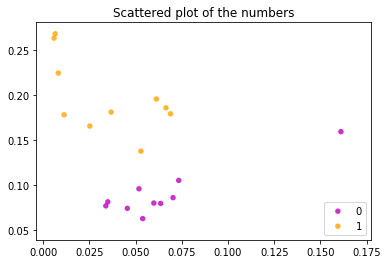

In [10]:
#---------------- VISUALIZE THE RESULT ----------------------
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for data, color, group in zip((g0,g1), ('m','orange'), ('0','1')):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    
plt.title('Scattered plot of the numbers')
plt.legend(loc=4)
plt.show()

The following features can be easily interpreted : We compute the mean of x² and y². As expected, the difference between 0 and 1 are mostly on the mean of (x-X)² (ones are thin, zeros are "larger" horizontally). Hence, the second feature here is useful, but the first one is not.

We have to be careful : Those features are clearly dependent on scaling, rotation and translation !

In [11]:
x=[]
y=[]
# Calculate for zeros
for im, nm in zip(zeros_im, zeros_names):
    moments = cv.moments(im);
    x.append(moments["m02"]/moments["m00"])
    y.append(moments["m20"]/moments["m00"])
g0 = (x,y)

x=[] 
y=[]
# Calculate for ones
for im, nm in zip(ones_im, ones_names):
    moments = cv.moments(im);
    x.append(moments["m02"]/moments["m00"])
    y.append(moments["m20"]/moments["m00"])
g1 = (x,y)    

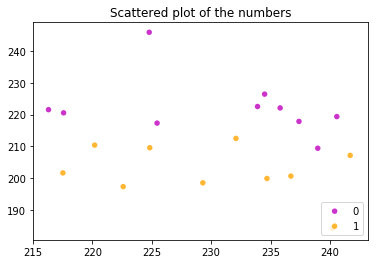

In [12]:
#---------------- VISUALIZE THE RESULT ----------------------
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for data, color, group in zip((g0,g1), ('m','orange'), ('0','1')):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    
plt.title('Scattered plot of the numbers')
plt.legend(loc=4)
plt.show()

We can then use the most useful features among the previous tries to get a very good differentiation based on moments :

In [13]:
x=[]
y=[]
# Calculate for zeros
for im, nm in zip(zeros_im, zeros_names):
    moments = cv.moments(im);
    x.append(moments["nu02"]*100)
    y.append(moments["m20"]/moments["m00"])
g0 = (x,y)

x=[] 
y=[]
# Calculate for ones
for im, nm in zip(ones_im, ones_names):
    moments = cv.moments(im);
    x.append(moments["nu02"]*100)
    y.append(moments["m20"]/moments["m00"])
g1 = (x,y)

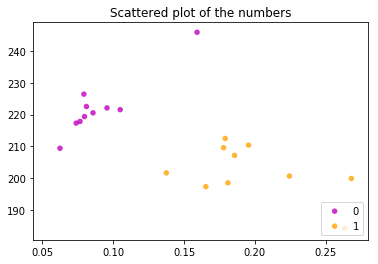

In [14]:
#---------------- VISUALIZE THE RESULT ----------------------
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for data, color, group in zip((g0,g1), ('m','orange'), ('0','1')):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    
plt.title('Scattered plot of the numbers')
plt.legend(loc=4)
plt.show()

## Convolution and Subsampling

Here, we filtered the image with horizontal and vertical sobel filters and then subsampled the filtered image. We do the same procedure again to extract 4 filtered images for each one. The average of the filtered images are feed into 2D fourier transform function. 

In [15]:
from scipy import ndimage
from skimage import filters, transform, measure, feature

def convolute_subsample(input_img, h_list, v_list, target_size):
    # Do convolutions
    horizontal_edge = filters.sobel_h(input_img)
    vertical_edge = filters.sobel_v(input_img) 
    
    # Subsample the images
    h_resample = measure.block_reduce(horizontal_edge,(target_size,target_size), np.max)
    v_resample =  measure.block_reduce(vertical_edge,(target_size,target_size), np.max)
    
    h_list.append(h_resample)
    v_list.append(v_resample)
    
    return h_resample, v_resample

Above is the function that does the convolution on the image using sobel filters and then subsample those. We have put two layers of these processes so that the average of the filtered images still contains some features of the numbers. 

In [16]:
#---------------Do Filtering and subsampling--------------------------------------------------------

feature_list_zero = []
feature_list_ones = []

for im, nm in zip(zeros_im, zeros_names):
    first_layer_h =[]
    first_layer_v =[]
    
    # First layer
    im_layer1_h, im_layer1_v = convolute_subsample(im, first_layer_h,first_layer_v ,1)


    second_layer_h =[]
    second_layer_v =[]
    # Second layer
    im_layer2_h1, im_layer2_v1 = convolute_subsample(im_layer1_h, second_layer_h,second_layer_v,4)
    im_layer2_h2, im_layer2_v2 = convolute_subsample(im_layer1_v, second_layer_h,second_layer_v,4)

    
    # Third layer
    mean_features = (im_layer2_h1 + im_layer2_v1 + im_layer2_h2 + im_layer2_v2 )/4
    
    feature_list_zero.append(mean_features)

    
for im, nm in zip(ones_im, ones_names):
    first_layer_h =[]
    first_layer_v =[]
    
    # First layer
    im_layer1_h, im_layer1_v = convolute_subsample(im, first_layer_h,first_layer_v ,1)


    second_layer_h =[]
    second_layer_v =[]
    # Second layer
    im_layer2_h1, im_layer2_v1 = convolute_subsample(im_layer1_h, second_layer_h,second_layer_v,4)
    im_layer2_h2, im_layer2_v2 = convolute_subsample(im_layer1_v, second_layer_h,second_layer_v,4)

    
    # Third layer
    mean_features = (im_layer2_h1 + im_layer2_v1 + im_layer2_h2 + im_layer2_v2 )/4
    
    feature_list_ones.append(mean_features)

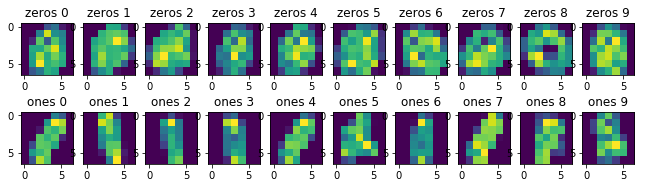

In [17]:
#-------------- Show the result of the processed images----------

fig, axes = plt.subplots(2, 10, figsize=(11, 3))
j =6
for i in range(10):
    axes[0][i].imshow(feature_list_zero[i]) #Display the result
    axes[0][i].set_title('zeros {}'.format(i))
    axes[1][i].imshow(feature_list_ones[i]) #Display the result
    axes[1][i].set_title('ones {}'.format(i))
plt.show()

Then we compute discrete Fourier Transform of the processed images. We have choosed the absolute value of first components of the computed discrete Fourier Transform since the output contains DC components in the low-order corner of the transformed axes. 

In [18]:
#------------- Compute the discrete Fourier transform -------
fft_list = []

for element in feature_list_zero:
    fft_ = np.fft.fft2(element)
    fft_list.append([x[0] for x in fft_])
for element in feature_list_ones:
    fft_ = np.fft.fft2(element)
    fft_list.append([x[0] for x in fft_])    
    
# Convert list to np array for easier computation
fft_list = np.array(fft_list)

# Take the absolute value of the fourier transfrom values.
fft_list = np.abs(fft_list)

In the following plot, we could see that zeros and ones are forming the distinct clusters. 

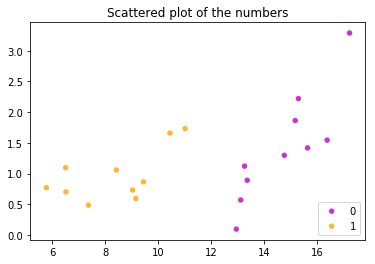

In [19]:
c1 = 0
c2 = 2
# Group the data for each numbers
g0 =(fft_list.transpose()[c1][0:10],fft_list.transpose()[c2][0:10])
g1 =(fft_list.transpose()[c1][10:20],fft_list.transpose()[c2][10:20])

#---------------- VISUALIZE THE RESULT ----------------------
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for data, color, group in zip((g0,g1), ('m','orange'), ('0','1')):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    
plt.title('Scattered plot of the numbers')
plt.legend(loc=4)
plt.show()

## HOG descriptors

Here, we are going to calculate the HOG descriptors of the each number images. We will firstly deskew the image so that it is invariant to the rotation and then apply HOG to the image. Since there are many features extracted, we apply PCA(Principal Component Analysis) on the extracted features to be able to project data to a lower demensional space. 

In [20]:
def deskew(img):
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
        # no deskewing needed. 
        return img.copy()
    # Calculate skew based on central momemts. 
    skew = m['mu11']/m['mu02']
    # Calculate affine transform to correct skewness. 
    M = np.float32([[1, skew, -0.5*28*skew], [0, 1, 0]])
    # Apply affine transform
    img = cv.warpAffine(img, M, (28, 28), flags=cv.WARP_INVERSE_MAP | cv.INTER_LINEAR)
    return img

First, we defined the deskew function that minimize the skewness of the handwirtten numbers. The following shows the result of the deskewed image. As shown, the numbers are positioned straight. 

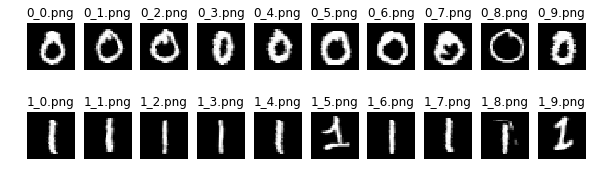

In [21]:
# Plot deskewed images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(10, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(deskew(im), cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(deskew(im), cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

Then we set up the parameters of the HOG descriptor. The window size is set to (28,28) as we want to consider whole image. The block and cell sizes are selected after testing. When cell size is too big, it is possible that HOG descritor cannot extract relevant features vectors of the image. On the other hand, if they are too small, the size of the feature vecotr would be too big. The nbins sets the number of bins in the histogram of gradients. Usually it is set to a value of 9 to capture gradients between 0 and 180 degrees in 20 degrees increments.

In [22]:
# Set up the HOG Descriptor
winSize = (28,28)
blockSize = (8,8)
blockStride = (4,4)
cellSize = (4,4)
nbins = 9
signedGradients = True
 
hog = cv.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)

Now, we compute the HOG features of the deskewed image using the HOG descriptor defined above. 

In [23]:
# Calculate HOG descriptors

feature_list_mean = [];
feature_list_test =[]
lables =[]

for im, nm in zip(zeros_im, zeros_names):
    deskew_im = deskew(im)
    descriptor = hog.compute(deskew_im)
    flattened_descriptor = [item for sublist in descriptor for item in sublist]
    feature_list_mean.append([np.mean(flattened_descriptor), np.std(flattened_descriptor)])
    feature_list_test.append(flattened_descriptor)
    lables.append(0)
    
for im, nm in zip(ones_im, ones_names):
    deskew_im = deskew(im)
    descriptor = hog.compute(deskew_im)
    flattened_descriptor = [item for sublist in descriptor for item in sublist]
    feature_list_mean.append([np.mean(flattened_descriptor), np.std(flattened_descriptor)])
    feature_list_test.append(flattened_descriptor)
    lables.append(1)    

To use PCA, import the library and define the PCA with n_components of 2 which keeps the best two components. Then we fit the extracted HOG feature vectors. 

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X= pca.fit_transform(feature_list_test)

# Group the data for each numbers
g0 =(X.transpose()[0][0:10],X.transpose()[1][0:10])
g1 =(X.transpose()[0][10:20],X.transpose()[1][10:20])

We can then use those two components to plot on the 2D plane. We could see the good differentiation based on the HOG feature vectors and using PCA for visualization.

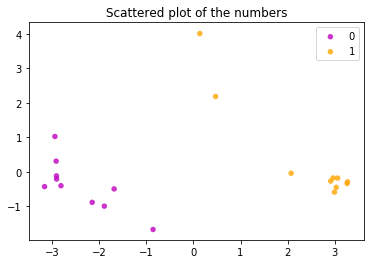

In [25]:

#---------------- VISUALIZE THE RESULT ----------------------
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for data, color, group in zip((g0,g1), ('m','orange'), ('0','1')):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    
plt.title('Scattered plot of the numbers')
plt.legend(loc=1)
plt.show()

## Distance Map

In the following, we are going to use one of the 1 and one of the 0 as references. We will then compare every other sample to those references using the distance map method on the contours. We will then label each sample according to the closest reference and count the right/wrong labels.

In [26]:
#---------------CONTOUR EXTRACTION--------------------------------------------------------

import cv2 as cv
import numpy as np

minimum_length = 28*28; #This variable tracks the shorter contour. We will later fit all contour so that they contain the same number of points.
labels = [];
contour_list = [];

for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    pic = np.zeros(im.shape) #Black background to plot the contours on
    im2, contours, hierarchy  = cv.findContours(im, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) #Find the external contour
    
    #Keep only the longer contour (to discard artefacts)
    contour_length = 0;
    for contour in contours:
        if len(contour)>contour_length:
            main_contour = contour;
            contour_length = len(contour)
    
    minimum_length = min(contour_length, minimum_length)
    
    cv.drawContours(pic, contours, -1, (255,255,255), 1) #Draw the external conto.ur
    #Store that contour and its label
    labels.append(0);
    contour_list.append(main_contour);
    
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    pic = np.zeros(im.shape) #Black background to plot the contours on
    im2, contours, hierarchy  = cv.findContours(im, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) #Find the external contour
    
    #Keep only the longer contour (to discard artefacts)
    contour_length = 0;
    for contour in contours:
        if len(contour)>contour_length:
            main_contour = contour;
            contour_length = len(contour)

    minimum_length = min(contour_length, minimum_length)        
            
    cv.drawContours(pic, main_contour, -1, (255,255,255), 1) #Draw the external contour    
    #Store that contour and its label
    labels.append(1);
    contour_list.append(main_contour);
    

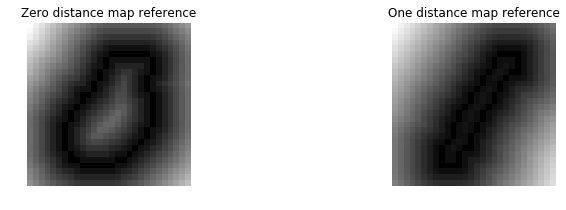

In [27]:
from scipy.ndimage.morphology import distance_transform_edt

#-------------------Distance Map References-----------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(12, 3))

pic = np.zeros(im.shape) #Black background to plot the contours on
cv.drawContours(pic, contour_list[0], -1, (255,255,255), 1) #Draw the external contour    
distance_ref_0 = np.zeros(im.shape)
distance_transform_edt(pic<127, sampling=None, return_distances=True, return_indices=False, distances=distance_ref_0, indices=None);
ax[0].imshow(distance_ref_0,cmap='gray')
ax[0].axis('off')
ax[0].set_title('Zero distance map reference')

pic = np.zeros(im.shape) #Black background to plot the contours on
cv.drawContours(pic, contour_list[10], -1, (255,255,255), 1) #Draw the external contour    
distance_ref_0 = np.zeros(im.shape)
distance_transform_edt(pic<127, sampling=None, return_distances=True, return_indices=False, distances=distance_ref_0, indices=None);
ax[1].imshow(distance_ref_0,cmap='gray')
ax[1].axis('off')
ax[1].set_title('One distance map reference')
plt.show()

Seeing those distance map, it is clear that the rotation and translation are going to be an issue. We will translate and rotate the contours to make them all centered and 'vertical'.
Scaling could also be an issue, but it doesn't look like an important one here.

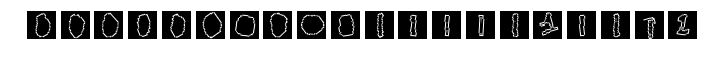

In [28]:
centered_list = [];
normalized_list = [];
new_pixel=(0,0);
h,w = im.shape
#---------------------Center the shapes--------------------------
for contour in contour_list:
    new_contour = []
    meanX = 0;
    meanY = 0;
    for pixel_a in contour:
        pixel = pixel_a[0]
        meanX = meanX + pixel[0] 
        meanY = meanY + pixel[1] 
    meanX = int(meanX/len(contour)) - int(h/2)
    meanY = int(meanY/len(contour)) - int(w/2)
    for pixel_a in contour:
        pixel = pixel_a[0]
        new_pixel = (pixel[0] - meanX,pixel[1] - meanY);
        new_contour.append(new_pixel);
    centered_list.append(new_contour);
#---------------------Rotate the shapes--------------------------
for contoura in centered_list:
    pic = np.zeros(im.shape)
    contourb = []
    contourb.append(np.asarray(contoura))
    cv.drawContours(pic, contourb, -1, (255,255,255), 1)
    moments = cv.moments(pic)
    angle = -(1/2)*np.arctan(2*moments["mu11"]/(moments["mu20"]-moments["mu02"]))
    rotated_image = rotateImage(pic,-angle*360/(2*np.pi))
    normalized_list.append(rotated_image)
    
fig, axes = plt.subplots(1, 20, figsize=(12, 3))
for ax, im in zip(axes, normalized_list ):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title('')
plt.show()

We now can compute reference distance maps that will be more robust to translations and rotation.

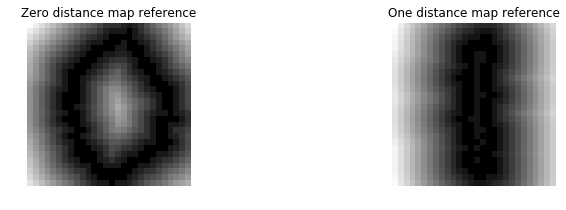

In [29]:
from scipy.ndimage.morphology import distance_transform_edt

#-------------------Distance Map References-----------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(12, 3))

pic = normalized_list[5]
distance_ref_0 = np.zeros(im.shape)
distance_transform_edt(pic<1, sampling=None, return_distances=True, return_indices=False, distances=distance_ref_0, indices=None);
ax[0].imshow(distance_ref_0,cmap='gray')
ax[0].axis('off')
ax[0].set_title('Zero distance map reference')

pic = normalized_list[10]  
distance_ref_1 = np.zeros(im.shape)
distance_transform_edt(pic<1, sampling=None, return_distances=True, return_indices=False, distances=distance_ref_1, indices=None);
ax[1].imshow(distance_ref_1,cmap='gray')
ax[1].axis('off')
ax[1].set_title('One distance map reference')
plt.show()

Let's now compare the samples to those references. For each sample, we compute the mean distances to the references and we keep the smallest one to label the sample.
Those two distances can be interpreted as features and we can display the feature space as previously.

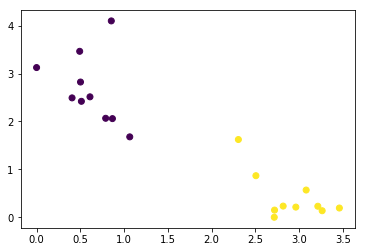

In [30]:
est_label = []
x = [];
y = [];
label =[];
count = 0;
for contoura in normalized_list:
    
    contour=((contoura>1)*1)
    distance0_pic = np.multiply(contour,distance_ref_0)
    distance1_pic = np.multiply(contour,distance_ref_1)
    distance0 = sum(sum(distance0_pic))/sum(sum(contour))
    distance1 = sum(sum(distance1_pic))/sum(sum(contour))
    x.append(distance0);
    y.append(distance1);
    label.append(int(count/10));
    count +=1;
    if distance0<distance1:
        est_label.append(0)
    else:
        est_label.append(1)
plt.scatter(x,y,c=labels)
plt.title('')
plt.show()

We can now print the labels we estimated. We got everything right !

In [31]:
print(est_label)
print(label)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 1.1 Data visualization

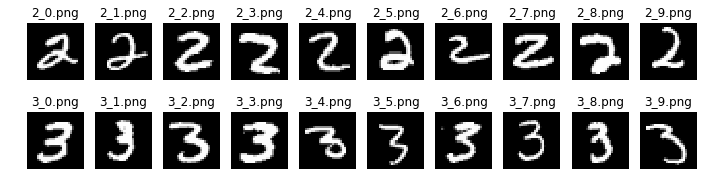

In [32]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

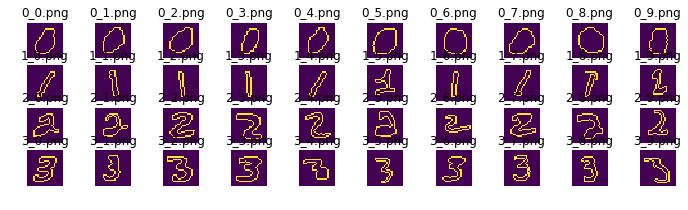

In [33]:
#---------------CONTOUR EXTRACTION--------------------------------------------------------

import cv2 as cv
import numpy as np

minimum_length = 28*28; #This variable tracks the shorter contour. We will later fit all contour so that they contain the same number of points.
labels = [];
contour_list = [];

fig, axes = plt.subplots(4, len(zeros_im), figsize=(12, 3))


for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    pic = np.zeros(im.shape) #Black background to plot the contours on
    im2, contours, hierarchy  = cv.findContours(im, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) #Find the external contour
    
    #Keep only the longer contour (to discard artefacts)
    contour_length = 0;
    for contour in contours:
        if len(contour)>contour_length:
            main_contour = contour;
            contour_length = len(contour)
    
    minimum_length = min(contour_length, minimum_length)
    
    cv.drawContours(pic, contours, -1, (255,255,255), 1) #Draw the external conto.ur
    ax.imshow(pic) #Display the result
    ax.axis('off')
    ax.set_title(nm)
    
    #Store that contour and its label
    labels.append(0);
    contour_list.append(main_contour);
    
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    pic = np.zeros(im.shape) #Black background to plot the contours on
    im2, contours, hierarchy  = cv.findContours(im, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) #Find the external contour
    
    #Keep only the longer contour (to discard artefacts)
    contour_length = 0;
    for contour in contours:
        if len(contour)>contour_length:
            main_contour = contour;
            contour_length = len(contour)

    minimum_length = min(contour_length, minimum_length)        
            
    cv.drawContours(pic, main_contour, -1, (255,255,255), 1) #Draw the external contour
    ax.imshow(pic) #Display the result
    ax.axis('off')
    ax.set_title(nm)
    
    #Store that contour and its label
    labels.append(1);
    contour_list.append(main_contour);

for ax, im, nm in zip(axes[2], twos_im, twos_names):
    pic = np.zeros(im.shape) #Black background to plot the contours on
    im2, contours, hierarchy  = cv.findContours(im, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) #Find the external contour
    
    #Keep only the longer contour (to discard artefacts)
    contour_length = 0;
    for contour in contours:
        if len(contour)>contour_length:
            main_contour = contour;
            contour_length = len(contour)

    minimum_length = min(contour_length, minimum_length)        
            
    cv.drawContours(pic, main_contour, -1, (255,255,255), 1) #Draw the external contour
    ax.imshow(pic) #Display the result
    ax.axis('off')
    ax.set_title(nm)
    
    #Store that contour and its label
    labels.append(2);
    contour_list.append(main_contour);
    
for ax, im, nm in zip(axes[3], threes_im, threes_names):
    pic = np.zeros(im.shape) #Black background to plot the contours on
    im2, contours, hierarchy  = cv.findContours(im, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) #Find the external contour
    
    #Keep only the longer contour (to discard artefacts)
    contour_length = 0;
    for contour in contours:
        if len(contour)>contour_length:
            main_contour = contour;
            contour_length = len(contour)

    minimum_length = min(contour_length, minimum_length)        
            
    cv.drawContours(pic, main_contour, -1, (255,255,255), 1) #Draw the external contour
    ax.imshow(pic) #Display the result
    ax.axis('off')
    ax.set_title(nm)
    
    #Store that contour and its label
    labels.append(3);
    contour_list.append(main_contour);
    
plt.show()

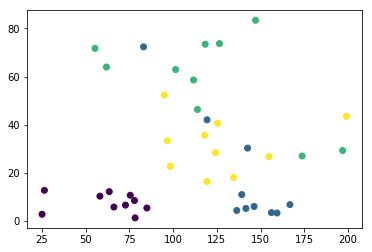

In [34]:
#-----------CONTOUR LENGTH NORMALIZATION-------------------------------
#All contours must have the same number of pixels.

normalized_contour_list = [];

for contour in contour_list:
    normalized_contour = [];
    Npoints_to_discard = len(contour)-minimum_length;#Number of points to discard
    
    if Npoints_to_discard>0: #compute the frequency at which we should discard points
        discard_interval = np.floor(len(contour)/Npoints_to_discard)
    else:
        discard_interval = minimum_length+1
    
    #Actually process the signal : Discard and form the complex signal
    points_added_in_a_row = 0
    points_discarded = 0;
    for k in range(0,len(contour)):
        if points_added_in_a_row==discard_interval-1 and points_discarded<Npoints_to_discard:
            points_added_in_a_row = 0
            points_discarded = points_discarded +1
        else:
            point = contour[k]
            normalized_contour.append(point[0,0]+point[0,1]*1j)  
            points_added_in_a_row = points_added_in_a_row+1
    normalized_contour_list.append(normalized_contour)
        
#--------------COMPUTE FFT---------------------------------------
fft_list = [];
for contour in normalized_contour_list:
    fft_list.append(np.fft.fft(contour))
#----------------EXTRACT 2 FEATURES AND PLOT----------------------
x = [];
y = [];
for contour in fft_list:
    x.append(np.absolute(contour[1]))
    y.append(np.absolute(contour[3]))
plt.scatter(x,y,c=labels)
plt.show()

### 1.3 Additional method(s)


## Moments as features

Only 2 normalized central moments as features are not enough to differentiate between 0,1,2 and 3.

In [35]:
x=[]
y=[]
# Calculate for zeros
for im, nm in zip(zeros_im, zeros_names):
    moments = cv.moments(im);
    x.append(moments["nu20"]*100)
    y.append(moments["nu02"]*100)
g0 = (x,y)

x=[] 
y=[]
# Calculate for ones
for im, nm in zip(ones_im, ones_names):
    moments = cv.moments(im);
    x.append(moments["nu20"]*100)
    y.append(moments["nu02"]*100)
g1 = (x,y)    

x=[]
y=[]
# Calculate for twos
for  im, nm in zip(twos_im, twos_names):
    moments = cv.moments(im);
    x.append(moments["nu20"]*100)
    y.append(moments["nu02"]*100)
g2 = (x,y)     

x=[]
y=[]
# Calculate for threes
for im, nm in zip(threes_im, threes_names):
    moments = cv.moments(im);
    x.append(moments["nu20"]*100)
    y.append(moments["nu02"]*100)
g3 = (x,y)    

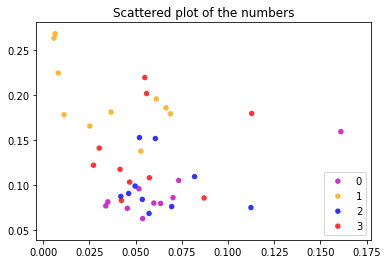

In [36]:
#---------------- VISUALIZE THE RESULT ----------------------
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for data, color, group in zip((g0,g1,g2,g3), ('m','orange','b','r'), ('0','1','2','3')):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    
plt.title('Scattered plot of the numbers')
plt.legend(loc=4)
plt.show()

Our "optimal" moment features we derived in the previous part are not very useful here either. 

In [37]:
x=[]
y=[]
# Calculate for zeros
for im, nm in zip(zeros_im, zeros_names):
    moments = cv.moments(im);
    x.append(moments["nu02"]*100)
    y.append(moments["m20"]/moments["m00"])
g0 = (x,y)

x=[] 
y=[]
# Calculate for ones
for im, nm in zip(ones_im, ones_names):
    moments = cv.moments(im);
    x.append(moments["nu02"]*100)
    y.append(moments["m20"]/moments["m00"])
g1 = (x,y)    

x=[]
y=[]
# Calculate for twos
for  im, nm in zip(twos_im, twos_names):
    moments = cv.moments(im);
    x.append(moments["nu02"]*100)
    y.append(moments["m20"]/moments["m00"])
g2 = (x,y)     

x=[]
y=[]
# Calculate for threes
for im, nm in zip(threes_im, threes_names):
    moments = cv.moments(im);
    x.append(moments["nu02"]*100)
    y.append(moments["m20"]/moments["m00"])
g3 = (x,y)    

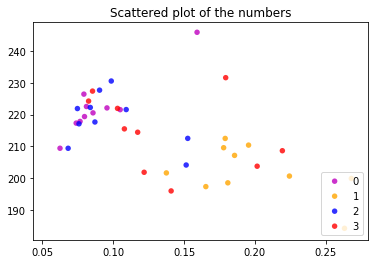

In [38]:
#---------------- VISUALIZE THE RESULT ----------------------
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for data, color, group in zip((g0,g1,g2,g3), ('m','orange','b','r'), ('0','1','2','3')):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    
plt.title('Scattered plot of the numbers')
plt.legend(loc=4)
plt.show()

## Convolution and Subsampling

Here, we do the same procedure as we did for the zeros and ones and observe the results.

In [39]:
#---------------Do Filtering and subsampling--------------------------------------------------------

feature_list_zero = []
feature_list_ones = []
feature_list_twos = []
feature_list_threes = []

for im, nm in zip(zeros_im, zeros_names):
    first_layer_h =[]
    first_layer_v =[]
    
    # First layer
    im_layer1_h, im_layer1_v = convolute_subsample(im, first_layer_h,first_layer_v ,1)


    second_layer_h =[]
    second_layer_v =[]
    # Second layer
    im_layer2_h1, im_layer2_v1 = convolute_subsample(im_layer1_h, second_layer_h,second_layer_v,4)
    im_layer2_h2, im_layer2_v2 = convolute_subsample(im_layer1_v, second_layer_h,second_layer_v,4)

    
    # Third layer
    mean_features = (im_layer2_h1 + im_layer2_v1 + im_layer2_h2 + im_layer2_v2 )/4
    
    feature_list_zero.append(mean_features)

    
for im, nm in zip(ones_im, ones_names):
    first_layer_h =[]
    first_layer_v =[]
    
    # First layer
    im_layer1_h, im_layer1_v = convolute_subsample(im, first_layer_h,first_layer_v ,1)


    second_layer_h =[]
    second_layer_v =[]
    # Second layer
    im_layer2_h1, im_layer2_v1 = convolute_subsample(im_layer1_h, second_layer_h,second_layer_v,4)
    im_layer2_h2, im_layer2_v2 = convolute_subsample(im_layer1_v, second_layer_h,second_layer_v,4)

    
    # Third layer
    mean_features = (im_layer2_h1 + im_layer2_v1 + im_layer2_h2 + im_layer2_v2 )/4
    
    feature_list_ones.append(mean_features)

for im, nm in zip(twos_im, twos_names):
    first_layer_h =[]
    first_layer_v =[]
    
    # First layer
    im_layer1_h, im_layer1_v = convolute_subsample(im, first_layer_h,first_layer_v ,1)


    second_layer_h =[]
    second_layer_v =[]
    # Second layer
    im_layer2_h1, im_layer2_v1 = convolute_subsample(im_layer1_h, second_layer_h,second_layer_v,4)
    im_layer2_h2, im_layer2_v2 = convolute_subsample(im_layer1_v, second_layer_h,second_layer_v,4)

    
    # Third layer
    mean_features = (im_layer2_h1 + im_layer2_v1 + im_layer2_h2 + im_layer2_v2 )/4
    
    feature_list_twos.append(mean_features)

    
for im, nm in zip(threes_im, threes_names):
    first_layer_h =[]
    first_layer_v =[]
    
    # First layer
    im_layer1_h, im_layer1_v = convolute_subsample(im, first_layer_h,first_layer_v ,1)


    second_layer_h =[]
    second_layer_v =[]
    # Second layer
    im_layer2_h1, im_layer2_v1 = convolute_subsample(im_layer1_h, second_layer_h,second_layer_v,4)
    im_layer2_h2, im_layer2_v2 = convolute_subsample(im_layer1_v, second_layer_h,second_layer_v,4)

    
    # Third layer
    mean_features = (im_layer2_h1 + im_layer2_v1 + im_layer2_h2 + im_layer2_v2 )/4
    
    feature_list_threes.append(mean_features)

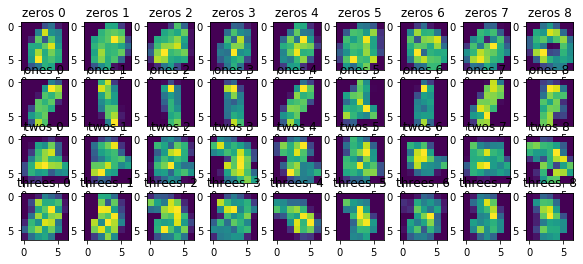

In [40]:
# Show the filtered images
fig, axes = plt.subplots(4, 9, figsize=(10, 4))
j =6
for i in range(9):
    axes[0][i].imshow(feature_list_zero[i]) #Display the result
    axes[0][i].set_title('zeros {}'.format(i))
    axes[1][i].imshow(feature_list_ones[i]) #Display the result
    axes[1][i].set_title('ones {}'.format(i))
    axes[2][i].imshow(feature_list_twos[i]) #Display the result
    axes[2][i].set_title('twos {}'.format(i))
    axes[3][i].imshow(feature_list_threes[i]) #Display the result
    axes[3][i].set_title('threes  {}'.format(i))
plt.show()

As we can see from  above, the filtered images are similar between twos and threes. We do the discrete Fouriere transform of those filtered images and then take the first components and compute the absolute values of those values. 

In [41]:
fft_list = []

for element in feature_list_zero:
    fft_ = np.fft.fft2(element)
    fft_list.append([x[0] for x in fft_])
for element in feature_list_ones:
    fft_ = np.fft.fft2(element)
    fft_list.append([x[0] for x in fft_])    
for element in feature_list_twos:
    fft_ = np.fft.fft2(element)
    fft_list.append([x[0] for x in fft_])    
for element in feature_list_threes:
    fft_ = np.fft.fft2(element)
    fft_list.append([x[0] for x in fft_])    
    
# Convert list to np array for easier computation
fft_list = np.array(fft_list)
# Take the absolute value
fft_list = np.abs(fft_list)

In [42]:
c1 = 0
c2 = 2
# Group the data for each numbers
g0 =(fft_list.transpose()[c1][0:10],fft_list.transpose()[c2][0:10])
g1 =(fft_list.transpose()[c1][10:20],fft_list.transpose()[c2][10:20])
g2 =(fft_list.transpose()[c1][20:30],fft_list.transpose()[c2][20:30])
g3 =(fft_list.transpose()[c1][30:40],fft_list.transpose()[c2][30:40])

As expected, the clusters of twos and threes are overlapped while ones and zeros has clear distinction between their clusters. Still, the result looks better than using moment features.

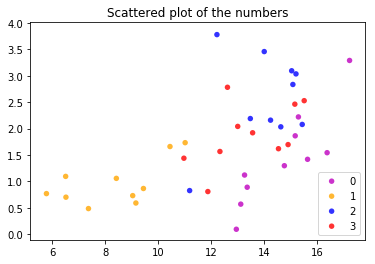

In [43]:
#---------------- VISUALIZE THE RESULT ----------------------
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for data, color, group in zip((g0,g1,g2,g3), ('m','orange','b','r'), ('0','1','2','3')):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    
plt.title('Scattered plot of the numbers')
plt.legend(loc=4)
plt.show()

## HOG descriptors

Using the same procedure as before, we could observe that this method works better than using moments as feature but still some of the number clusters are overlapped. 

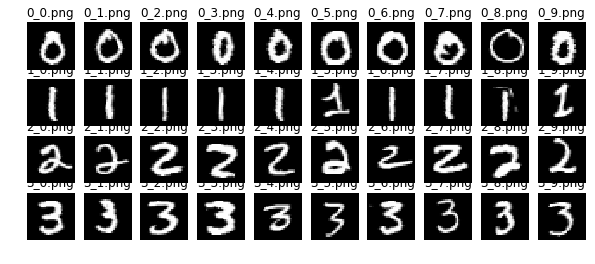

In [44]:
# Plot deskewed images
fig, axes = plt.subplots(4, len(zeros_im), figsize=(10, 4))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(deskew(im), cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(deskew(im), cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[2], twos_im, twos_names):
    ax.imshow(deskew(im), cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[3], threes_im, threes_names):
    ax.imshow(deskew(im), cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

We extract the HOG feature vectors with parameters set previously.

In [45]:
# Calculate the HOG feature vecotors

feature_list_mean = [];
feature_list_test =[]
lables =[]

for im, nm in zip(zeros_im, zeros_names):
    deskew_im = deskew(im)
    descriptor = hog.compute(deskew_im)
    flattened_descriptor = [item for sublist in descriptor for item in sublist]
    feature_list_mean.append([np.mean(flattened_descriptor), np.sum(flattened_descriptor)/np.count_nonzero(flattened_descriptor)])
    feature_list_test.append(flattened_descriptor)
    lables.append(0)
    
for im, nm in zip(ones_im, ones_names):
    deskew_im = deskew(im)
    descriptor = hog.compute(deskew_im)
    flattened_descriptor = [item for sublist in descriptor for item in sublist]
    feature_list_mean.append([np.mean(flattened_descriptor), np.sum(flattened_descriptor)/np.count_nonzero(flattened_descriptor)])
    feature_list_test.append(flattened_descriptor)
    lables.append(1) 
    
for im, nm in zip(twos_im, twos_names):
    deskew_im = deskew(im)
    descriptor = hog.compute(deskew_im)
    flattened_descriptor = [item for sublist in descriptor for item in sublist]
    feature_list_mean.append([np.mean(flattened_descriptor), np.sum(flattened_descriptor)/np.count_nonzero(flattened_descriptor)])
    feature_list_test.append(flattened_descriptor)
    lables.append(2) 

for im, nm in zip(threes_im, threes_names):
    deskew_im = deskew(im)
    descriptor = hog.compute(deskew_im)
    flattened_descriptor = [item for sublist in descriptor for item in sublist]
    feature_list_mean.append([np.mean(flattened_descriptor),np.sum(flattened_descriptor)/np.count_nonzero(flattened_descriptor)])
    feature_list_test.append(flattened_descriptor)
    lables.append(3) 

We defined PCA with n_components as 2 since we want to get the most important 2 components that makes the features distinctive among the calculated features to plot on the 2D plane.

In [46]:
# Define PCA
pca = PCA(n_components=2)
X= pca.fit_transform(feature_list_test)

# Group the data for each numbers
g0 =(X.transpose()[0][0:10],X.transpose()[1][0:10])
g1 =(X.transpose()[0][10:20],X.transpose()[1][10:20])
g2 =(X.transpose()[0][20:30],X.transpose()[1][20:30])
g3 =(X.transpose()[0][30:40],X.transpose()[1][30:40])

From the plot below, we could see that zeros and ones are well seperated from twos and threes. However, the clusters of the twos and threes are overlapped. Still, the result is better than previous results. 

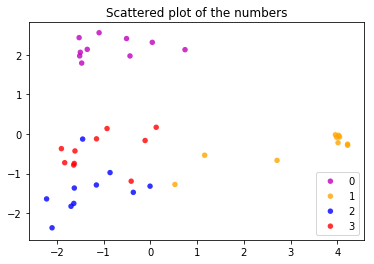

In [47]:
#---------------- VISUALIZE THE RESULT ----------------------
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for data, color, group in zip((g0,g1,g2,g3), ('m','orange','b','r'), ('0','1','2','3')):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    
plt.title('Scattered plot of the numbers')
plt.legend(loc=4)
plt.show()

## Distance Map

Using the same procedure as before would lead to 4 different distances, which would somehow violate the rule of this exercise. Lets see what append with those 4 features and if we can "combine" them to only extract 2 features.

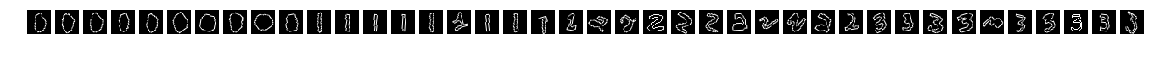

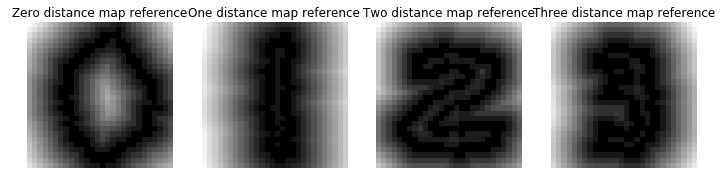

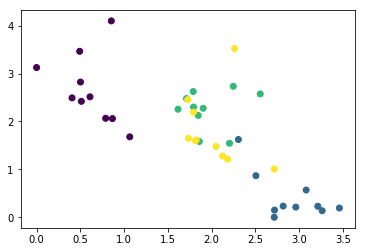

Number of errors : 10
[2, 0, 0, 3, 2, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [48]:
#---------------CONTOUR EXTRACTION--------------------------------------------------------

import cv2 as cv
import numpy as np

minimum_length = 28*28; #This variable tracks the shorter contour. We will later fit all contour so that they contain the same number of points.
labels = [];
contour_list = [];

for im, nm in zip( zeros_im, zeros_names):
    pic = np.zeros(im.shape) #Black background to plot the contours on
    im2, contours, hierarchy  = cv.findContours(im, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) #Find the external contour
    
    #Keep only the longer contour (to discard artefacts)
    contour_length = 0;
    for contour in contours:
        if len(contour)>contour_length:
            main_contour = contour;
            contour_length = len(contour)
    
    minimum_length = min(contour_length, minimum_length)
    
    cv.drawContours(pic, contours, -1, (255,255,255), 1) #Draw the external conto.ur

    
    #Store that contour and its label
    labels.append(0);
    contour_list.append(main_contour);
    
for  im, nm in zip( ones_im, ones_names):
    pic = np.zeros(im.shape) #Black background to plot the contours on
    im2, contours, hierarchy  = cv.findContours(im, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) #Find the external contour
    
    #Keep only the longer contour (to discard artefacts)
    contour_length = 0;
    for contour in contours:
        if len(contour)>contour_length:
            main_contour = contour;
            contour_length = len(contour)

    minimum_length = min(contour_length, minimum_length)        
            
    cv.drawContours(pic, main_contour, -1, (255,255,255), 1) #Draw the external contour

    
    #Store that contour and its label
    labels.append(1);
    contour_list.append(main_contour);

for im, nm in zip( twos_im, twos_names):
    pic = np.zeros(im.shape) #Black background to plot the contours on
    im2, contours, hierarchy  = cv.findContours(im, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) #Find the external contour
    
    #Keep only the longer contour (to discard artefacts)
    contour_length = 0;
    for contour in contours:
        if len(contour)>contour_length:
            main_contour = contour;
            contour_length = len(contour)

    minimum_length = min(contour_length, minimum_length)        
            
    cv.drawContours(pic, main_contour, -1, (255,255,255), 1) #Draw the external contour
    
    #Store that contour and its label
    labels.append(2);
    contour_list.append(main_contour);
    
for  im, nm in zip( threes_im, threes_names):
    pic = np.zeros(im.shape) #Black background to plot the contours on
    im2, contours, hierarchy  = cv.findContours(im, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) #Find the external contour
    
    #Keep only the longer contour (to discard artefacts)
    contour_length = 0;
    for contour in contours:
        if len(contour)>contour_length:
            main_contour = contour;
            contour_length = len(contour)

    minimum_length = min(contour_length, minimum_length)        
            
    cv.drawContours(pic, main_contour, -1, (255,255,255), 1) #Draw the external contour

    
    #Store that contour and its label
    labels.append(3);
    contour_list.append(main_contour);


centered_list = [];
normalized_list = [];
new_pixel=(0,0);
h,w = im.shape
#---------------------Center the shapes--------------------------
for contour in contour_list:
    new_contour = []
    meanX = 0;
    meanY = 0;
    for pixel_a in contour:
        pixel = pixel_a[0]
        meanX = meanX + pixel[0] 
        meanY = meanY + pixel[1] 
    meanX = int(meanX/len(contour)) - int(h/2)
    meanY = int(meanY/len(contour)) - int(w/2)
    for pixel_a in contour:
        pixel = pixel_a[0]
        new_pixel = (pixel[0] - meanX,pixel[1] - meanY);
        new_contour.append(new_pixel);
    centered_list.append(new_contour);
#---------------------Rotate the shapes--------------------------
for contoura in centered_list:
    pic = np.zeros(im.shape)
    contourb = []
    contourb.append(np.asarray(contoura))
    cv.drawContours(pic, contourb, -1, (255,255,255), 1)
    moments = cv.moments(pic)
    angle = -(1/2)*np.arctan(2*moments["mu11"]/(moments["mu20"]-moments["mu02"]))
    rotated_image = rotateImage(pic,-angle*360/(2*np.pi))
    normalized_list.append(rotated_image)
    
fig, axes = plt.subplots(1, 40, figsize=(20, 6))
for ax, im in zip(axes, normalized_list ):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title('')
plt.show()

from scipy.ndimage.morphology import distance_transform_edt

#-------------------Distance Map References-----------------------------------------------
fig, ax = plt.subplots(1,4, figsize=(12, 3))

pic = normalized_list[5]
distance_ref_0 = np.zeros(im.shape)
distance_transform_edt(pic<1, sampling=None, return_distances=True, return_indices=False, distances=distance_ref_0, indices=None);
ax[0].imshow(distance_ref_0,cmap='gray')
ax[0].axis('off')
ax[0].set_title('Zero distance map reference')

pic = normalized_list[10]  
distance_ref_1 = np.zeros(im.shape)
distance_transform_edt(pic<1, sampling=None, return_distances=True, return_indices=False, distances=distance_ref_1, indices=None);
ax[1].imshow(distance_ref_1,cmap='gray')
ax[1].axis('off')
ax[1].set_title('One distance map reference')


pic = normalized_list[22]  
distance_ref_2 = np.zeros(im.shape)
distance_transform_edt(pic<1, sampling=None, return_distances=True, return_indices=False, distances=distance_ref_2, indices=None);
ax[2].imshow(distance_ref_2,cmap='gray')
ax[2].axis('off')
ax[2].set_title('Two distance map reference')

pic = normalized_list[38]  
distance_ref_3 = np.zeros(im.shape)
distance_transform_edt(pic<1, sampling=None, return_distances=True, return_indices=False, distances=distance_ref_3, indices=None);
ax[3].imshow(distance_ref_3,cmap='gray')
ax[3].axis('off')
ax[3].set_title('Three distance map reference')
plt.show()

est_label = []
x = [];
y = [];
label =[];
count = 0;
for contoura in normalized_list:
    
    contour=((contoura>1)*1)
    distance0_pic = np.multiply(contour,distance_ref_0)
    distance1_pic = np.multiply(contour,distance_ref_1)
    distance2_pic = np.multiply(contour,distance_ref_2)
    distance3_pic = np.multiply(contour,distance_ref_3)
    distance0 = sum(sum(distance0_pic))/sum(sum(contour))
    distance1 = sum(sum(distance1_pic))/sum(sum(contour))
    distance2 = sum(sum(distance2_pic))/sum(sum(contour))
    distance3 = sum(sum(distance3_pic))/sum(sum(contour))
    x.append(distance0);
    y.append(distance1);
    label.append(int(count/10));
    count +=1;
    if min((distance0,distance1,distance2,distance3))==distance0:
        est_label.append(0)
    elif min((distance0,distance1,distance2,distance3))==distance1:
        est_label.append(1)
    elif min((distance0,distance1,distance2,distance3))==distance2:
        est_label.append(2)
    elif min((distance0,distance1,distance2,distance3))==distance3:
        est_label.append(3)
plt.scatter(x,y,c=labels)
plt.title('')
plt.show()

print('Number of errors : {}'.format(40-sum((np.equal(est_label,label))*1)))
print(est_label)
print(label)

First of all, even using the 4 distances as a test to identify the numbers, we have 10 errors among the 40 samples. Changing the reference sample might improve this result, but we will try to combine those 4 distances into only 2 features.

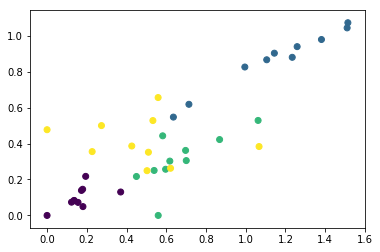

In [49]:
x=[];
y=[];
label= []
for contoura in normalized_list:
    
    contour=((contoura>1)*1)
    distance0_pic = np.multiply(contour,distance_ref_0)
    distance1_pic = np.multiply(contour,distance_ref_1)
    distance2_pic = np.multiply(contour,distance_ref_2)
    distance3_pic = np.multiply(contour,distance_ref_3)
    distance0 = sum(sum(distance0_pic))/sum(sum(contour))
    distance1 = sum(sum(distance1_pic))/sum(sum(contour))
    distance2 = sum(sum(distance2_pic))/sum(sum(contour))
    distance3 = sum(sum(distance3_pic))/sum(sum(contour))
    x.append(distance0*distance3/(distance1+1));
    y.append(distance0*distance2/(distance3+1+distance1));
    label.append(int(count/10));
    count +=1;
plt.scatter(x,y,c=labels)
plt.title('')
plt.show()

We tried a lot of combinations of the distances. The two features displayed here doesn't allow us to clearly differentiate 0,1,2 and 3 but some areas start to appear. The main confusion is between 2 and 3, which are yellow and green dots. 

It is still better than what we had with the moments.